# Error Supression

Error Suppression refers to techniques aimed at reducing the probability of errors occurring in quantum operations, without necessarily detecting or correcting them directly. One important Error Supression method is the Dynamic Decoupling.

## Dynamical Decoupling

Dynamical Decoupling can be used to reduce errors caused by decoherence. Decoherence occurs when a qubit is idle for a longer time and disturbs nearby qubits, creating errors. This unwanted interaction can lead to disturbances that alter the state or outcomes of the affected qubits.

<div>
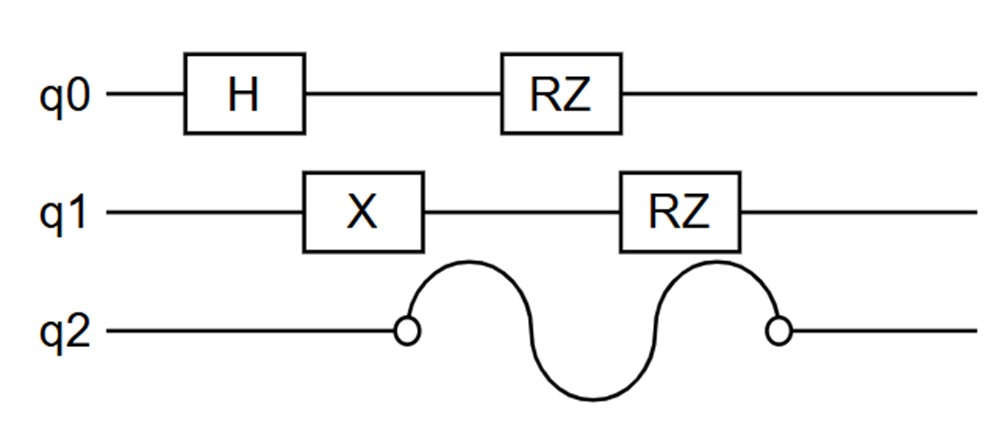
</div>

To reduce errors, idle qubits are kept active by applying identity operations, typically implemented using pairs of X gates. This helps mitigate decoherence by maintaining qubit coherence during idle periods.

<div>
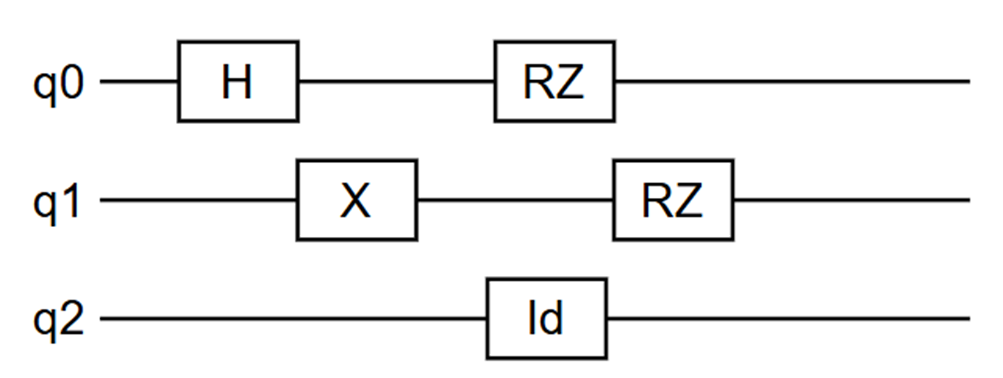
</div>

One drawback of Dynamical Decoupling is that the added gates can introduce small errors. Furthermore, the error rates of gates can vary from system to system and even from qubit to qubit. To reduce this problem, we examine the error rates from a system and use gates with the minimal error for Dynamical Decoupling on each qubit.

We address this issue through the following steps:

1. Retrieve the backend properties.

2. Filter the available basis gates.

3. Sort the error rates for each qubit.

4. Select the self-inverse basis gate with the lowest error rate.

5. Apply the selected basis gate in the dynamical decoupling sequence.

Each step is detailed below with corresponding code examples:

In [1]:
from qiskit.transpiler.passes import PadDynamicalDecoupling
from qiskit.transpiler.instruction_durations import InstructionDurations
from qiskit.transpiler.target import Target
from qiskit.transpiler import PassManager
from qiskit.circuit import library as lib
from qiskit.transpiler.passes import ALAPScheduleAnalysis
from qiskit import QuantumCircuit
from qiskit.transpiler import Target
from qiskit.visualization import timeline_drawer
from qiskit.transpiler import PassManager, InstructionDurations, Target, CouplingMap
from qiskit_ibm_runtime.fake_provider import FakeEssexV2
from qiskit_ibm_runtime.fake_provider import FakeArmonkV2

DEBUG = False

# In the future also ignore parameterized rotational gates
IGNORE_GATES = set(["id", "measure"])

# Dict keys
GATE_NAME = "gate_name"
ERROR = "error"

### Create Example Circuit

In [2]:
circ = QuantumCircuit(4)
circ.h(0)
circ.cx(0, 1)
circ.cx(1, 2)
circ.cx(2, 3)
circ.measure_all()

circ.draw()

┌───┐                ░ ┌─┐         
   q_0: ┤ H ├──■─────────────░─┤M├─────────
        └───┘┌─┴─┐           ░ └╥┘┌─┐      
   q_1: ─────┤ X ├──■────────░──╫─┤M├──────
             └───┘┌─┴─┐      ░  ║ └╥┘┌─┐   
   q_2: ──────────┤ X ├──■───░──╫──╫─┤M├───
                  └───┘┌─┴─┐ ░  ║  ║ └╥┘┌─┐
   q_3: ───────────────┤ X ├─░──╫──╫──╫─┤M├
                       └───┘ ░  ║  ║  ║ └╥┘
meas: 4/════════════════════════╩══╩══╩══╩═
                                0  1  2  3

### Create Example Backend
Specifying the supported gates and their respective errors and durations. 

In [3]:
durations = InstructionDurations(
    [("h", None, 50), ("cx", [0, 1], 700), ("reset", None, 10),
     ("cx", [1, 2], 200), ("cx", [2, 3], 300),
     ("x", None, 50), ("measure", None, 1000)],
    dt=1e-7
)
target = Target.from_configuration(
    ["h", "cx", "reset", "x", "measure"],
    num_qubits=4,
    coupling_map=CouplingMap.from_line(4, bidirectional=False),
    instruction_durations=durations,
    dt=1e-7,
)

# Mock errors for x gates
inst_props = target["x"]
for qubits, props in inst_props.items():
    if props is not None:
        props.error = 0.2

# Mock errors for h gates
inst_props = target["h"]
for qubits, props in inst_props.items():
    if props is not None:
        if (qubits[0] == 1):
            props.error = 0.3
        else:
            props.error = 0.1

print(target)

Target
Number of qubits: 4
Instructions:
	h
		(0,):
			Duration: 5e-06 sec.
			Error Rate: 0.1
		(1,):
			Duration: 5e-06 sec.
			Error Rate: 0.3
		(2,):
			Duration: 5e-06 sec.
			Error Rate: 0.1
		(3,):
			Duration: 5e-06 sec.
			Error Rate: 0.1
	reset
		(0,):
			Duration: 1e-06 sec.
		(1,):
			Duration: 1e-06 sec.
		(2,):
			Duration: 1e-06 sec.
		(3,):
			Duration: 1e-06 sec.
	x
		(0,):
			Duration: 5e-06 sec.
			Error Rate: 0.2
		(1,):
			Duration: 5e-06 sec.
			Error Rate: 0.2
		(2,):
			Duration: 5e-06 sec.
			Error Rate: 0.2
		(3,):
			Duration: 5e-06 sec.
			Error Rate: 0.2
	measure
		(0,):
			Duration: 0.0001 sec.
		(1,):
			Duration: 0.0001 sec.
		(2,):
			Duration: 0.0001 sec.
		(3,):
			Duration: 0.0001 sec.
	cx
		(0, 1):
			Duration: 7e-05 sec.
		(1, 2):
			Duration: 2e-05 sec.
		(2, 3):
			Duration: 3e-05 sec.




One can see that in this example $X$ Gates have a higher error rate than $H$ Gates except for qubit 1. So using $H$ Gates would be beneficial except for qubit 1.

### Identify the best available basis gates

For each qubit search for the single qubit basis gate that has the minimal error.

In [4]:
"""
    For a target returns a dictiory of minimal error gate for each qubit
"""
def get_errors(target):
    # Dict of minimal error gate for each qubit in the form: {qubit_nr: {min_error, gate_name}}
    errors = {}

    # Get all single-qubit gate names available in the target
    single_qubit_gates = set()

    for inst in target.instructions:
        if inst[0].num_qubits == 1:
            single_qubit_gates.add(inst[0].name)

    if DEBUG:
        print("Single-qubit gates:", single_qubit_gates)

    # Ignore some single-qubit gates not used for decoupling (e.g., measurment and identity)
    filtered_single_qubit_gates = single_qubit_gates - IGNORE_GATES

    # Find minimal error gates
    for gate_name in filtered_single_qubit_gates:

        inst_props = target[gate_name]
        for qubits, props in inst_props.items():
            # If we have an error for the gate and qubit
            if(props is not None and props.error is not None):
                curr_error = props.error
                
                # Ignore gates that have no error at all, as probably are not supported on the hardware
                if curr_error == 0.0:
                    break

                # Get qubit (as we have only single qubit gates here)
                qubit = qubits[0]

                # If there was a previously found error
                if (qubit in errors):
                    prev_error = errors[qubit][ERROR]

                    # Save the current gate if it has less error
                    if(curr_error < prev_error):
                        errors[qubit] = {ERROR: curr_error, GATE_NAME: gate_name}

                else:
                    errors[qubit] = {ERROR: curr_error, GATE_NAME: gate_name}

    if DEBUG:
        print(errors)

    return errors

### Add dynamical decoupling for each qubit to a pass manager

In [5]:
"""
    Uses an error dictionary to add single qubit PadDynamicalDecoupling with minimal error single qubit gates to a pass manager.
"""
def add_dyn_decoupling(pass_manager, target, errors, durations=None):

    if durations is None:
        durations = target.durations

    # For each qbit run super with minimal error gate
    for qubit_key, val in errors.items():
        gate_name = val[GATE_NAME]

        instruction = target.operation_from_name(gate_name)
        if DEBUG:
            print("Added decoupling:")
            print(instruction)
            print(qubit_key)
        dd_sequence = [instruction, instruction]
        
        dec = PadDynamicalDecoupling(durations, dd_sequence, qubits=[qubit_key])

        pass_manager.append(ALAPScheduleAnalysis(durations))
        pass_manager.append(dec)

    return pass_manager

### Baseline without using Dynamical Decoupling

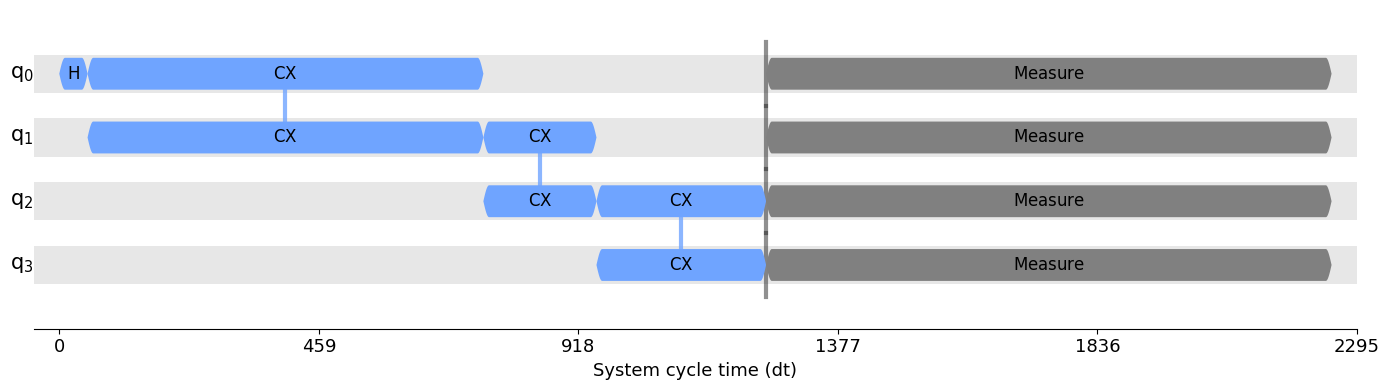

In [6]:
# Create pass manager
pass_manager = PassManager()
pass_manager.scheduling = PassManager([ALAPScheduleAnalysis(durations)])

# Run the circuit through the pass manager
transpiled_circuit = pass_manager.run(circ)
timeline_drawer(transpiled_circuit, target=target)

### Using standard Dynamical Decoupling

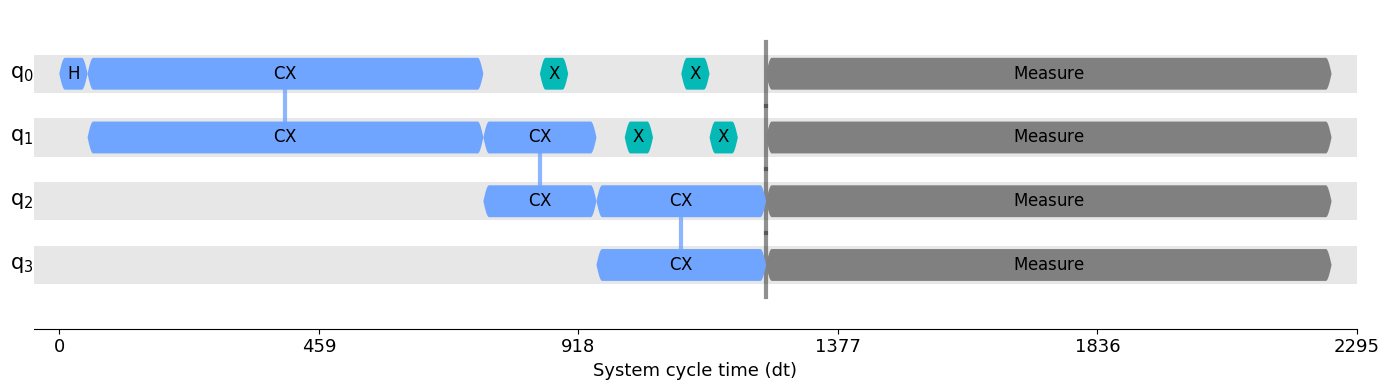

In [7]:
# Create pass manager
scheduling = PassManager()
scheduling.append(ALAPScheduleAnalysis(durations))

# Use balanced X-X sequence on all qubits
dd_sequence = [lib.XGate(), lib.XGate()]
scheduling.append(PadDynamicalDecoupling(durations, dd_sequence=dd_sequence))

# Run the circuit through the pass manager
transpiled_circuit = scheduling.run(circ)
timeline_drawer(transpiled_circuit, target=target)

### With our Single Qubit Optimized Dynamical Decoupling

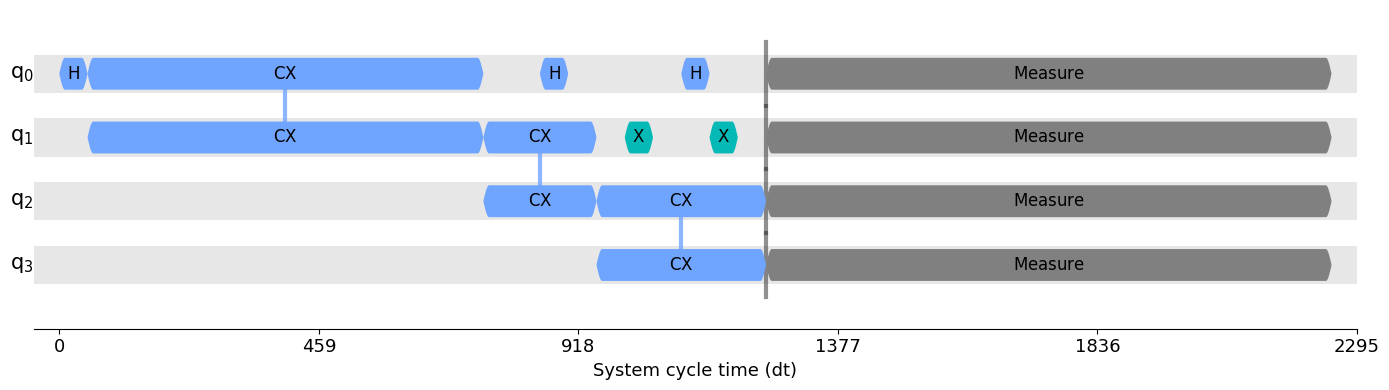

In [8]:
# Get target specific errors
errors = get_errors(target)

# Create pass manager
scheduling = PassManager()
scheduling = add_dyn_decoupling(scheduling, target, errors, durations)

# Run the circuit through the pass manager
transpiled_circuit = scheduling.run(circ)
timeline_drawer(transpiled_circuit, target=target)

**For qubit 0 $H$ gates and for qubit 1 $X$ gates according to the mocked error rates were chosen, which shows that our optimization works.**

### Backend Compatiblity 
So far we only showed how our approach can be applied to a single example. Nevertheless, the provided functionality is generic and can be provided for every (fake) Qiskit backend.

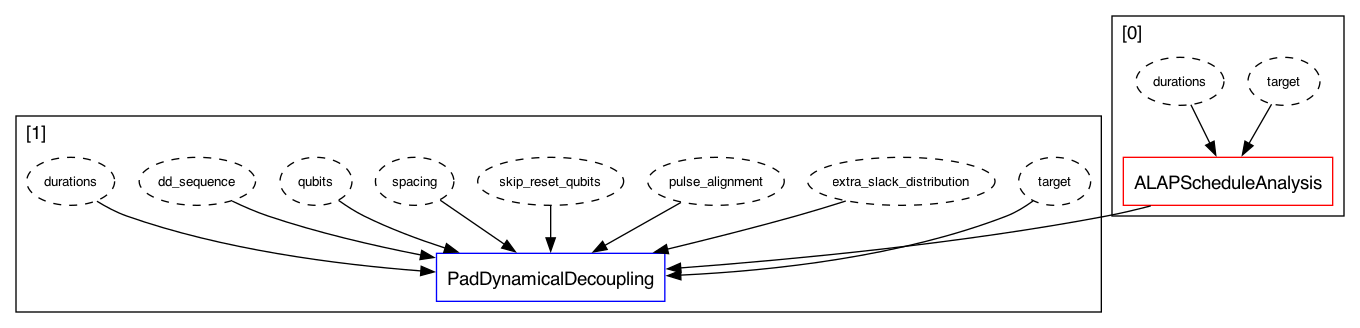

In [9]:
backend = FakeArmonkV2() # 1 qubit -> 2 passes
target=backend.target
durations = target.durations()

# Get target specific errors
errors = get_errors(target)

# Create pass manager
scheduling = PassManager()
scheduling = add_dyn_decoupling(scheduling, target, errors, durations)

# Show created pass manager
scheduling.draw()

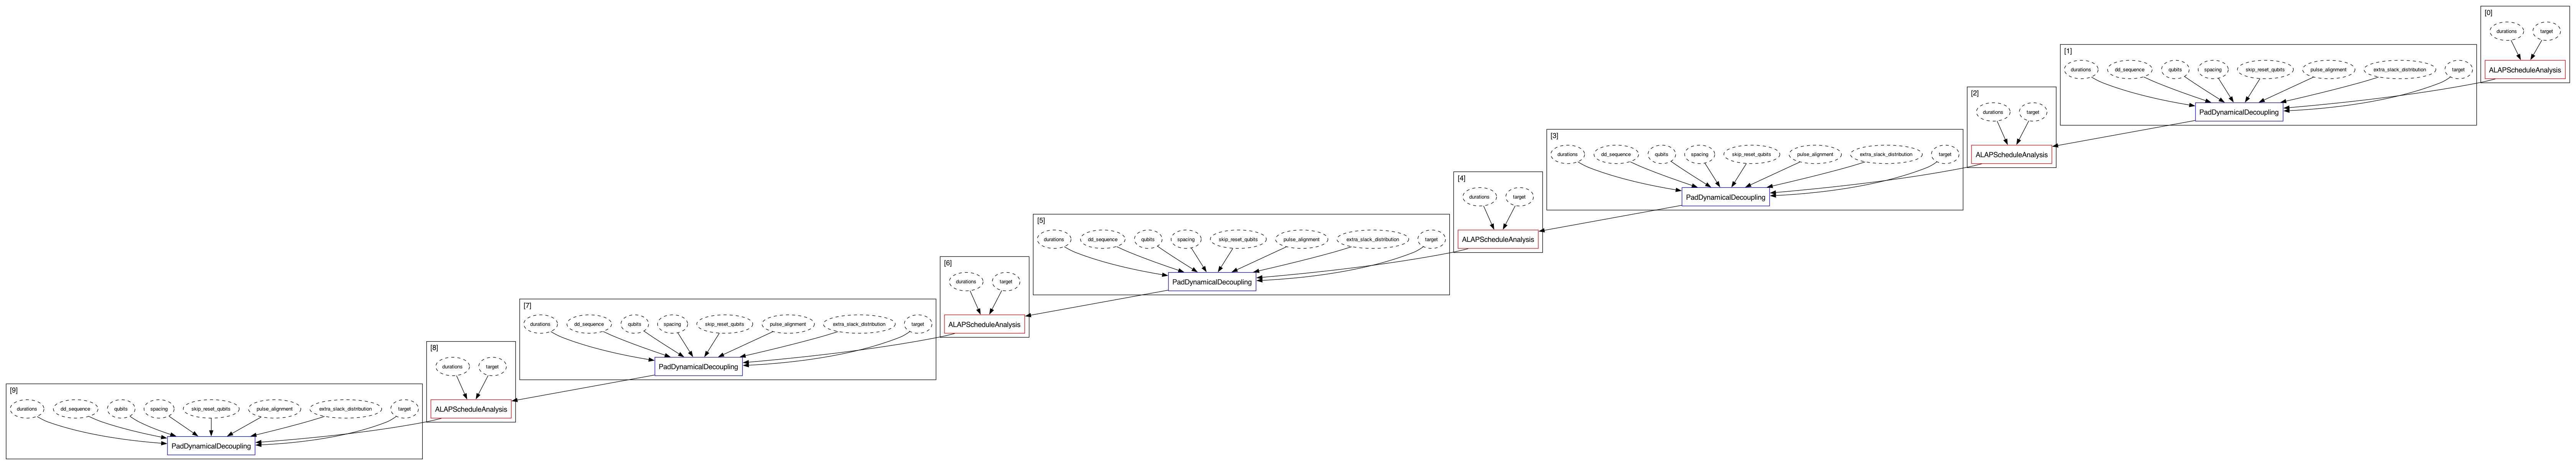

In [10]:
backend = FakeEssexV2() # 5 qubits -> 10 passes
target=backend.target
durations = target.durations()

# Get target specific errors
errors = get_errors(target)

# Create pass manager
scheduling = PassManager()
scheduling = add_dyn_decoupling(scheduling, target, errors, durations)

# Show created pass manager
scheduling.draw()

Sadly, we did not manage to create an example circuit working with a fake backend in the given timeframe. 